# UTILS

In [5]:
import io
import tarfile
import time
import zlib

import numpy as np

PREFIX = 'data/'
SUFFIX = '.npy.z'

#Probably an issue with this turing to binary

class NpyTarWriter(object):
    def __init__(self, fname):
        self.tfile = tarfile.open(fname, 'w|')

    def add(self, arr, name):

        sio = io.BytesIO()
        np.save(sio, arr)
        zbuf = zlib.compress(sio.getvalue())
        sio.close()

        zsio = io.BytesIO(zbuf)
        tinfo = tarfile.TarInfo('{}{}{}'.format(PREFIX, name, SUFFIX))
        tinfo.size = len(zbuf)
        tinfo.mtime = time.time()
        zsio.seek(0)
        self.tfile.addfile(tinfo, zsio)
        zsio.close()

    def close(self):
        self.tfile.close()

class NpyTarReader(object):
    def __init__(self, fname):
        self.fname = fname
        self.tfile = tarfile.open(self.fname, 'r|')

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        entry = self.tfile.next()
        if entry is None:
            raise StopIteration()
        name = entry.name[len(PREFIX): -len(SUFFIX)]
        fileobj = self.tfile.extractfile(entry)
        buf = zlib.decompress(fileobj.read())
        arr = np.load(io.BytesIO(buf))
        return arr, name

    def length(self):
        return len(self.tfile.getnames())

    def reopen(self):
        self.tfile.close()
        self.tfile = tarfile.open(self.fname, 'r|')

    def close(self):
        self.tfile.close()

In [ ]:
#new npy tar writer

import tarfile
import io
import time
import numpy as np

class NpyTarWriter(object):
    def __init__(self, fname):
        self.tfile = tarfile.open(fname, 'w|')

    def add(self, arr, name):
        # Scale the floating-point array
        scaling_factor = 65535.0
        uint16_output = (arr * scaling_factor).astype(np.uint16)

        # Create a BytesIO buffer and save the NumPy array as a binary NumPy file
        sio = io.BytesIO()
        np.save(sio, uint16_output)
        sio.seek(0)

        tinfo = tarfile.TarInfo('{}{}{}'.format(PREFIX, name, SUFFIX))
        tinfo.size = len(sio.getvalue())
        tinfo.mtime = time.time()
        sio.seek(0)
        self.tfile.addfile(tinfo, sio)

    def close(self):
        self.tfile.close()




In [ ]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from skimage import measure

def save_output(output_arr, output_size, output_dir, file_idx):
    plot_out_arr = np.array([])
    with_border_arr = np.zeros([34, 34, 34])
    for x_i in range(0, output_size):
        for y_j in range(0, output_size):
            for z_k in range(0, output_size):
                plot_out_arr = np.append(plot_out_arr, output_arr[x_i, y_j, z_k])

    text_save = np.reshape(plot_out_arr, (output_size * output_size * output_size))
    np.savetxt(output_dir + '/volume' + str(file_idx) + '.txt', text_save)

    output_image = np.reshape(plot_out_arr, (output_size, output_size, output_size)).astype(np.float32)

    for x_i in range(0, output_size):
        for y_j in range(0, output_size):
            for z_k in range(0, output_size):
                with_border_arr[x_i + 1, y_j + 1, z_k + 1] = output_image[x_i, y_j, z_k]

    if not np.any(with_border_arr):
        verts, faces, normals, values = [], [], [], []
    else:
        verts, faces, normals, values = measure.marching_cubes_lewiner(with_border_arr, level = 0.0, gradient_direction = 'descent')
        faces = faces + 1

    obj_save = open(output_dir + '/volume' + str(file_idx) + '.obj', 'w')
    for item in verts:
        obj_save.write('v {0} {1} {2}\n'.format(item[0], item[1], item[2]))
    for item in normals:
        obj_save.write('vn {0} {1} {2}\n'.format(-item[0], -item[1], -item[2]))
    for item in faces:
        obj_save.write('f {0}//{0} {1}//{1} {2}//{2}\n'.format(item[0], item[2], item[1]))
    obj_save.close()

    output_image = np.rot90(output_image)
    x, y, z = output_image.nonzero()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(x, y, z, zdir = 'z', c = 'red')
    plt.savefig(output_dir + '/volume' + str(file_idx) + '.png')
    plt.close()

In [ ]:
#my code without visualizations

#Reverses scaling factor shouldnt

import numpy as np
import os


def save_output(output_arr, output_size, output_dir, file_idx):
    # Reverse the scaling factor to convert back to uint16
    reversed_scaling_factor = 65535.0

    # Convert the floating-point array to uint16
    uint16_output = (output_arr * reversed_scaling_factor).astype(np.uint16)

    # Create a directory for the output if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Initialize the NpyTarWriter with the output tar file name
    tar_file = os.path.join(output_dir, f'volumes.tar')
    tar_writer = NpyTarWriter(tar_file)

    # Add the uint16 output array to the tar file
    tar_writer.add(uint16_output, f'volume{file_idx}')

    # Close the tar file after adding the volume
    tar_writer.close()


In [2]:
##NEW NEW PICKLING
import numpy as np
import os

def save_output(output_arr, output_size, output_dir, file_idx):
    # Reverse the scaling factor to convert back to uint16
    reversed_scaling_factor = 65535.0

    # Convert the floating-point array to uint16
    uint16_output = (output_arr * reversed_scaling_factor).astype(np.uint16)

    # Create a directory for the output if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the individual .npy file in the directory
    npy_filename = os.path.join(output_dir, f'volume{file_idx}.npy')
    np.save(npy_filename, uint16_output)

    # Initialize the NpyTarWriter with the output tar file name
    tar_file = os.path.join(output_dir, 'volumes.tar')
    tar_writer = NpyTarWriter(tar_file)

    # Add the uint16 output array to the tar file
    tar_writer.add(uint16_output, f'volume{file_idx}')

    # Close the tar file after adding the volume
    tar_writer.close()


In [6]:
#probably a binerization in npywriter or unit or scale is causing a problem
#vanila
def save_output(output_arr, output_size, output_dir, file_idx):
    # Create a directory for the output if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the individual .npy file in the directory without scaling or changing data type
    npy_filename = os.path.join(output_dir, f'volume{file_idx}.npy')
    np.save(npy_filename, output_arr)

#VAE

Base Model Architecture
- 4 in; 4 plus one out
- Ks, stride: 3,1 3,2 3,1 3,2; 3,1 3,2 3,1 4,2 3,1
- filters 8 16 32 64; 64 32 16 8 1
- valid, same; v,s,v,s;s,v,s,v,s
- latent 128

Model 1 Architecture -
- 4 in; 4 plus one out
- Ks, stride: 3,1 3,2 3,1 3,2; 3,1 3,2 3,1 4,2 3,1
- filters  16 32 64 128; 128 64 32 16 1
- valid, same; v,s,v,s;s,v,s,v,s
- latent 128
Results
- more filter not better

Base Model Architecture(2x latent)
- 4 in; 4 plus one out
- Ks, stride: 3,1 3,2 3,1 3,2; 3,1 3,2 3,1 4,2 3,1
- filters 8 16 32 64; 64 32 16 8 1
- valid, same; v,s,v,s;s,v,s,v,s
- latent 256

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_shape = (1, 32, 32, 32)
z_dim = 256

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)

    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_in))
    enc_conv2 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv2))
    enc_conv4 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv3))

    enc_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'glorot_normal',
            activation = 'elu')(Flatten()(enc_conv4)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'glorot_normal',
            activation = 'elu')(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,7,7,7))(dec_fc1)

    dec_conv1 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (4, 4, 4),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv3))
    dec_conv5 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            data_format = 'channels_first')(dec_conv4))

    decoder = Model(dec_in, dec_conv5)

    dec_conv5 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv5)

    return {'inputs': enc_in,
            'outputs': dec_conv5,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

#VAE 2x length Model 2

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_shape = (1, 32, 32, 32)
z_dim = 128

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)


    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_in))
    enc_conv2 = BatchNormalization()(
        Conv3D(
            filters = 256,
            kernel_size = (4, 4, 4),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv2))
    enc_conv4 = BatchNormalization()(
        Conv3D(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv3))
    enc_conv5 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv4))
    enc_conv6 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv5))
    enc_conv7 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv6))
    enc_conv8 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv7))
    enc_conv9 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv8))
    enc_conv10 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv9))
    enc_conv11 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv10))
    enc_conv12 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv11))
    enc_conv13 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv12))
    enc_conv14 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv13))
    enc_conv15 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv14))
    enc_conv16 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv15))
    enc_conv17 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv16))
    enc_conv18 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv17))
    enc_conv19 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv18))
    enc_conv20 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv19))
    enc_conv21 = BatchNormalization()(
        Conv3D(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv20))
    enc_conv22 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv21))
    enc_conv23 = BatchNormalization()(
        Conv3D(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv22))
    enc_conv24 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv23))

    enc_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'glorot_normal',
            activation = 'elu')(Flatten()(enc_conv24)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'glorot_normal',
            activation = 'elu')(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,7,7,7))(dec_fc1)

    dec_conv1 = BatchNormalization()(
        Conv3DTranspose(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = BatchNormalization()(
        Conv3DTranspose(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = BatchNormalization()(
        Conv3DTranspose(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = BatchNormalization()(
        Conv3DTranspose(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv3))
    dec_conv5 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv4))
    dec_conv6 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv5))
    dec_conv7 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv6))
    dec_conv8 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv7))
    dec_conv9 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv8))
    dec_conv10 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv9))
    dec_conv11 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv10))
    dec_conv12 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv11))
    dec_conv13 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv12))
    dec_conv14 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv13))
    dec_conv15 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv14))
    dec_conv16 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv15))
    dec_conv17 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv16))
    dec_conv18 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv17))
    dec_conv19 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv18))
    dec_conv20 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv19))
    dec_conv21 = BatchNormalization()(
        Conv3DTranspose(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv20))
    dec_conv22 = BatchNormalization()(
        Conv3DTranspose(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv21))
    dec_conv23 = BatchNormalization()(
        Conv3DTranspose(
            filters = 256,
            kernel_size = (4, 4, 4),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv22))
    dec_conv24 = BatchNormalization()(
        Conv3DTranspose(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv23))
    dec_conv25 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            data_format = 'channels_first')(dec_conv24))

    decoder = Model(dec_in, dec_conv25)

    dec_conv25 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv25)

    return {'inputs': enc_in,
            'outputs': dec_conv25,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

#VAE 11 layers Model 3

#Model 4 Base but with new


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_shape = (1, 32, 32, 32)
z_dim = 2744

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)

    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_in))
    enc_conv2 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (5, 5, 5),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(enc_conv2))

    enc_fc1 = BatchNormalization()(
        Dense(
            units = 2744,
            kernel_initializer = 'glorot_normal',
            activation = 'elu')(Flatten()(enc_conv3)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 2744,
            kernel_initializer = 'glorot_normal',
            activation = 'elu')(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,14,14,14))(dec_fc1)

    dec_conv1 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (5, 5, 5),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'elu',
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            data_format = 'channels_first')(dec_conv3))

    decoder = Model(dec_in, dec_conv4)

    dec_conv4 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv4)

    return {'inputs': enc_in,
            'outputs': dec_conv4,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

#Model 5
- extra layers
- dif activation
- more units and filters
- less batch norm
- prelu
- specified linear output function
- too complex reducing filter
- still too complex prelu or layers or latent space probably not filters

TOOO COMPLEX LATENT SPACE MEMORY ISSUES

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import PReLU


input_shape = (1, 32, 32, 32)
z_dim = 2744

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)

    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_in))
    enc_conv2 = (
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv2))
    enc_conv4 = (
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'relu',
            kernel_regularizer=l2(0.001),
            data_format = 'channels_first')(enc_conv3))


    enc_fc1 = BatchNormalization()(
        Dense(
            units=2744,
            kernel_initializer='glorot_normal',
            activation= 'relu',
            kernel_regularizer=l2(0.001))(Flatten()(enc_conv4)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 2744,
            kernel_initializer = 'glorot_normal',
            activation = 'relu')(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,14,14,14))(dec_fc1)

    dec_conv1 = (
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = (
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = BatchNormalization()(
        Conv3DTranspose(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = 'relu',
            kernel_regularizer=l2(0.001),
            data_format = 'channels_first')(dec_conv3))
    dec_conv5 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            activation='linear',
            kernel_initializer = 'glorot_normal',
            data_format = 'channels_first')(dec_conv4))

    decoder = Model(dec_in, dec_conv5)

    dec_conv5 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv5)

    return {'inputs': enc_in,
            'outputs': dec_conv5,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

# Model 6 back to 7x7x7 latent space

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import PReLU

input_shape = (1, 32, 32, 32)
z_dim = 256

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)

    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_in))
    enc_conv2 = (
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv2))
    enc_conv4 = (
        Conv3D(
            filters = 512,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv3))

    enc_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'glorot_normal',
            activation = PReLU())(Flatten()(enc_conv4)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'glorot_normal',
            activation = PReLU())(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,7,7,7))(dec_fc1)

    dec_conv1 = BatchNormalization()(
        Conv3DTranspose(
            filters = 512,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = (
        Conv3DTranspose(
            filters = 256,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = (
        Conv3DTranspose(
            filters = 64,
            kernel_size = (4, 4, 4),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv3))
    dec_conv5 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            data_format = 'channels_first')(dec_conv4))

    decoder = Model(dec_in, dec_conv5)

    dec_conv5 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv5)

    return {'inputs': enc_in,
            'outputs': dec_conv5,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

#Model 7


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import PReLU

input_shape = (1, 32, 32, 32)
z_dim = 256

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)

    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_in))
    enc_conv2 = (
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv2))
    enc_conv4 = (
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv3))
    enc_conv5 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv4))
    enc_conv6 = (
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv5))
    enc_conv7 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv6))
    enc_conv8 = (
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv7))

    enc_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'glorot_normal',
            activation = PReLU())(Flatten()(enc_conv8)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'glorot_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'glorot_normal',
            activation = PReLU())(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,7,7,7))(dec_fc1)

    dec_conv1 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = (
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = (
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv3))
    dec_conv5 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv4))
    dec_conv6 = (
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv5))
    dec_conv7 = BatchNormalization()(
        Conv3DTranspose(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv6))
    dec_conv8 = (
        Conv3DTranspose(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            activation = PReLU(),
            data_format = 'channels_first')(dec_conv7))
    dec_conv9 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'glorot_normal',
            data_format = 'channels_first')(dec_conv8))

    decoder = Model(dec_in, dec_conv9)

    dec_conv9 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv9)

    return {'inputs': enc_in,
            'outputs': dec_conv9,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

#Model 8 64

In [ ]:
#/content/drive/MyDrive/npy_brain_volumes_comp_64.tar

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import PReLU

input_shape = (1, 64, 64, 64)
z_dim = 1024

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)

    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(enc_in))
    enc_conv2 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(enc_conv2))
    enc_conv4 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(enc_conv3))
    enc_conv5 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv4))
    enc_conv6 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(enc_conv5))
    enc_conv7 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(enc_conv6))

    enc_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)))(Flatten()(enc_conv7)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'he_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'he_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)))(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,7,7,7))(dec_fc1)

    dec_conv1 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv3))
    dec_conv5 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv4))
    dec_conv6 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv5))
    dec_conv7 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv6))
    dec_conv8 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            data_format = 'channels_first')(dec_conv7))

    decoder = Model(dec_in, dec_conv8)

    dec_conv8 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv8)

    return {'inputs': enc_in,
            'outputs': dec_conv8,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

#Model 8 32


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import PReLU

input_shape = (1, 32, 32, 32)
z_dim = 1024

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)

    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(enc_in))
    enc_conv2 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(enc_conv2))
    enc_conv4 = BatchNormalization()(
        Conv3D(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(enc_conv3))
    enc_conv5 = BatchNormalization()(
        Conv3D(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(),
            data_format = 'channels_first')(enc_conv4))

    enc_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)))(Flatten()(enc_conv5)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'he_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'he_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)))(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,7,7,7))(dec_fc1)

    dec_conv1 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = BatchNormalization()(
        Conv3DTranspose(
            filters = 128,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv3))
    dec_conv5 = BatchNormalization()(
        Conv3DTranspose(
            filters = 64,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = PReLU(alpha_initializer=Constant(value=0.25)),
            data_format = 'channels_first')(dec_conv4))
    dec_conv6 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            data_format = 'channels_first')(dec_conv5))

    decoder = Model(dec_in, dec_conv6)

    dec_conv6 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv6)

    return {'inputs': enc_in,
            'outputs': dec_conv6,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

#Model 8 128

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv3D, Dense, Flatten, Lambda, Reshape, Conv3DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import PReLU

input_shape = (1, 128, 128, 128)
z_dim = 1024

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape = (batch, dim))

    return mu + K.exp(0.5 * sigma) * epsilon

def get_model():
    enc_in = Input(shape = input_shape)

    enc_conv1 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_in))
    enc_conv2 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv1))
    enc_conv3 = BatchNormalization()(
        Conv3D(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv2))
    enc_conv4 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv3))
    enc_conv5 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv4))
    enc_conv6 = BatchNormalization()(
        Conv3D(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv5))
    enc_conv7 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv6))
    enc_conv8 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv6))
    enc_conv9 = BatchNormalization()(
        Conv3D(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(enc_conv7))

    enc_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'he_normal',
            activation = 'relu')(Flatten()(enc_conv9)))
    mu = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'he_normal',
            activation = None)(enc_fc1))
    sigma = BatchNormalization()(
        Dense(
            units = z_dim,
            kernel_initializer = 'he_normal',
            activation = None)(enc_fc1))
    z = Lambda(
        sampling,
        output_shape = (z_dim, ))([mu, sigma])

    encoder = Model(enc_in, [mu, sigma, z])

    dec_in = Input(shape = (z_dim, ))

    dec_fc1 = BatchNormalization()(
        Dense(
            units = 343,
            kernel_initializer = 'he_normal',
            activation = 'relu')(dec_in))
    dec_unflatten = Reshape(
        target_shape = (1,7,7,7))(dec_fc1)

    dec_conv1 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_unflatten))
    dec_conv2 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv1))
    dec_conv3 = BatchNormalization()(
        Conv3DTranspose(
            filters = 32,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv2))
    dec_conv4 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv3))
    dec_conv5 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'valid',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv4))
    dec_conv6 = BatchNormalization()(
        Conv3DTranspose(
            filters = 16,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv5))
    dec_conv7 = BatchNormalization()(
        Conv3DTranspose(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv6))
    dec_conv8 = BatchNormalization()(
        Conv3DTranspose(
            filters = 8,
            kernel_size = (3, 3, 3),
            strides = (2, 2, 2),
            padding = 'same',
            kernel_initializer = 'he_normal',
            activation = 'relu',
            data_format = 'channels_first')(dec_conv7))
    dec_conv9 = BatchNormalization(
        beta_regularizer = l2(0.001),
        gamma_regularizer = l2(0.001))(
        Conv3DTranspose(
            filters = 1,
            kernel_size = (3, 3, 3),
            strides = (1, 1, 1),
            padding = 'same',
            kernel_initializer = 'he_normal',
            data_format = 'channels_first')(dec_conv8))

    decoder = Model(dec_in, dec_conv9)

    dec_conv9 = decoder(encoder(enc_in)[2])

    vae = Model(enc_in, dec_conv9)

    return {'inputs': enc_in,
            'outputs': dec_conv9,
            'mu': mu,
            'sigma': sigma,
            'z': z,
            'encoder': encoder,
            'decoder': decoder,
            'vae': vae}

#Train descriptions

**Base** hyperparmeters - base model
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.005
- momentum = 0.9
- batch_size = 10
- epoch_num = 150
- beta = 0.1

Results
- loss: 0.2788 - mse: 0.0125 - val_loss: 0.2946 - val_mse: 0.0000e+00 - lr: 0.0050




Test1 - base model
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.005
- momentum = 0.9
- batch_size = 10
- epoch_num = 1000
- beta = 0.1

Results
- loss: 0.0070 - mse: 0.0046 - val_loss: 0.0099 - val_mse: 0.0000e+00 - lr: 0.0050
- 4mins
- std getting too small

Test2 wild guess learn one thing - base model
- learning_rate_1 = 0.00005
- learning_rate_2 = 0.005
- momentum = 0.8
- batch_size = 5
- epoch_num = 2000
- beta = 0.01
- optimizer = adam

Results
- Epoch 289/2000
5/5 [==============================] - 0s 60ms/step - loss: 0.0061 - mse: 0.0042 - val_loss: 0.0061 - val_mse: 0.0000e+00 - lr: 0.005
- no progress not converging model particulalry latent needs to be more complex bigger latent filters and conv

Base 2 Test3 - model 2
- new model new base
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.005
- momentum = 0.9
- batch_size = 10
- epoch_num = 1000
- beta = 0.01
- optimizer = adam

Results
- Epoch 289/2000
5/5 [==============================] - 0s 60ms/step - loss: 0.0061 - mse: 0.0042 - val_loss: 0.0061 - val_mse: 0.0000e+00 - lr: 0.005
- no progress not converging model particulalry latent needs to be more complex bigger latent filters and conv

base 3(batch 5) test 4 - model 3 Vae #2
- new model
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.001
- momentum = 0.9
- batch_size = !5!
- epoch_num = 150
- beta = 0.01
- optimizer = adam

results
- gpu memory issue
- multiple channels times the size in flatten of feed forward 1

sgd is much slower check adam prop for local minima
can tell where training maxes out might need a new loss metric learning rate may be important beta seems important. sgd seems to give incremental progress for larger models

base 4 test 5 - model base (2x latent space)
- new model
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.005
- momentum = 0.9
- batch_size = 10
- epoch_num = 1500 (training less convergence)
- beta = 0.01
- optimizer = sgd

results
- better mse after aprx. 300 epochs, everything is still converging try longer Epoch 1000/1000
5/5 [==============================] - 0s 89ms/step - loss: 0.0644 - mse: 0.0042 - val_loss: 0.0988 - val_mse: 0.0000e+00 - lr: 0.0050
Epoch 1500/1500
5/5 [==============================] - 0s 84ms/step - loss: 0.0176 - mse: 0.0046 - val_loss: 0.0313 - val_mse: 0.0000e+00 - lr: 0.0050

- less stable training then previous and slower convergence

Base 2 Test6 - model base 2x latent
- new model new base
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.005
- momentum = 0.9
- batch_size = 10
- epoch_num = 1500
- beta = 0.01
- optimizer = adam

Results
- Epoch 289/2000
5/5 [==============================] - 0s 60ms/step - loss: 0.0061 - mse: 0.0042 - val_loss: 0.0061 - val_mse: 0.0000e+00 - lr: 0.005
- faster convergence with bigger latent space
- not converging model particulalry latent needs to be more complex bigger latent filters and conv

Base 2 Test7 - model 3 more layers 2x latent
- new model new base
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.001
- momentum = 0.9
- batch_size = 10
- epoch_num = 1500
- beta = 0.01
- optimizer = adam

Results
- Epoch 289/2000
5/5 [==============================] - 0s 60ms/step - loss: 0.0061 - mse: 0.0042 - val_loss: 0.0061 - val_mse: 0.0000e+00 - lr: 0.005 STILL STUCK AT .0061
- faster convergence with bigger latent space
- need a larger latent space end of encoder end of
- not converging model particulalry latent needs to be more complex bigger latent filters and conv

model 4 base 2 14x14x14
- new model new base
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.001
- momentum = 0.9
- batch_size = 10
- epoch_num = 1500
- beta = 0.01
- optimizer = adam

Results
- Epoch 289/2000
5/5 [==============================] - 0s 60ms/step - loss: 0.0061 - mse: 0.0042 - val_loss: 0.0061 - val_mse: 0.0000e+00 - lr: 0.005 STILL STUCK AT .0061
- faster convergence with bigger latent space
- need a larger latent space end of encoder end of
- not converging model particulalry latent needs to be more complex bigger latent filters and conv



model 5 base 2 14x14x14
- new model new base
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.001
- momentum = 0.9
- batch_size = 10
- epoch_num = 1500
- beta = 0.01
- optimizer = adam

Results
- Epoch 1177/1500
5/5 [==============================] - 2s 385ms/step - loss: 0.0073 - mse: 0.0041 - val_loss: 0.0073 - val_mse: 0.0000e+00 - lr: 0.0050

- faster convergence with bigger latent space
- need a larger latent space end of encoder end of
- not converging model particulalry latent needs to be more complex bigger latent filters and conv
- too complex unless filters are chalked



model 5 base 2NEW 14x14x14 test 2
- new model new base
- learning_rate_1 = 0.0001
- learning_rate_2 = 0.001
- momentum = 0.9
- batch_size = 5!!!!
- epoch_num = 1500
- beta = 0.01
- optimizer = adam

Results
- Epoch 1177/1500
5/5 [==============================] - 2s 385ms/step - loss: 0.0073 - mse: 0.0041 - val_loss: 0.0073 - val_mse: 0.0000e+00 - lr: 0.0050

- Changed to relu and doubled increased filter sizes
- not converging model particulalry latent needs to be more complex bigger latent filters and conv
- too complex unless filters are chalked



model 8 128

batch size reduced to five and filters more unstable training time

#TRAIN

In [ ]:
#elu or relu to make values positive

In [4]:
#split into test and train
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss
from keras.callbacks import History
from tensorflow.keras.layers import PReLU
from tensorflow.keras.initializers import Constant


#from VAE import *
#from utils import npytar

learning_rate_1 = 0.0001
learning_rate_2 = 0.08
learning_rate_3 = 0.000001
momentum = 0.9
batch_size = 5
epoch_num = 150

scaling_factor = 1.0 / 65535.0  # Divide by the maximum possible value for uint16


def data_loader(fname):
    reader = NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype=np.float32)  # Change dtype to float32
    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        # Scale the uint16 array to float32
        xc[ix] = (x.astype(np.float32) * scaling_factor)
    return xc


#def weighted_binary_crossentropy(target, output):
   # loss = -(98.0 * target * K.log(output) + 2.0 * (1.0 - target) * K.log(1.0 - output)) / 100.0
   # return loss
#def reconstruction_loss(y_true, y_pred):
    # Calculate the mean squared error for 3D reconstruction
    #mse = K.mean(K.square(y_true - y_pred), axis=(1, 2, 3))
    #return mse

#def kl_loss(z_mean, z_log_sigma):
    # Calculate the KL divergence loss for the latent space
    #kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
    #kl_loss = K.sum(kl_loss, axis=-1)
    #kl_loss *= -0.5
    #return kl_loss

#reconstruction_loss = reconstruction_loss(inputs, outputs)
###kl_loss = kl_loss(z_mean, z_log_sigma)


def learning_rate_scheduler(epoch, lr):
    if epoch >= 1:
        lr = learning_rate_2
    elif epoch >= 50:
        lr = learning_rate_3
    return lr



In [10]:
if __name__ == '__main__':
    model = get_model()


    inputs = model['inputs']
    outputs = model['outputs']
    mu = model['mu']
    sigma = model['sigma']
    z = model['z']


    encoder = model['encoder']
    decoder = model['decoder']

    plot_model(encoder, to_file = 'vae_encoder_128.pdf', show_shapes = True)
    plot_model(decoder, to_file = 'vae_decoder_128.pdf', show_shapes = True)

    vae = model['vae']


    # kl_div = -0.5 * K.mean(1 + 2 * sigma - K.square(mu) - K.exp(2 * sigma))
    #voxel_loss = K.cast(K.mean(weighted_binary_crossentropy(inputs, K.clip(sigmoid(outputs), 1e-7, 1.0 - 1e-7))), 'float32') # + kl_div
    #vae.add_loss(vae_loss)
    kl_loss = -0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
    kl_loss = K.mean(kl_loss)

    # Define the MSE loss
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))

    # Define the VAE loss
    beta = 0.00001  # Adjust the beta value as needed to control the trade-off
    vae_loss = reconstruction_loss + (beta * kl_loss)

    vae.add_loss(vae_loss)

    sgd = SGD(lr = learning_rate_1, momentum = momentum, nesterov = True)
    vae.compile(optimizer = 'adam', loss=None, metrics = 'mse')


    plot_model(vae, to_file = 'vae.pdf', show_shapes = True)

    data_train = data_loader('/content/drive/My Drive/npy_brain_volumes_comp_128.tar')
    history = History()

    vae.fit(
        data_train, data_train,
        epochs = epoch_num,
        batch_size = batch_size,
        validation_data = (data_train, None),
        callbacks = [LearningRateScheduler(learning_rate_scheduler), history]
    )

    vae.save_weights('vae_128.h5')

Epoch 1/150
10/10 [==============================] - 33s 2s/step - loss: 1.1770 - mse: 1.0430 - val_loss: 997553.8750 - val_mse: 0.0000e+00 - lr: 0.0010
Epoch 2/150
10/10 [==============================] - 10s 1s/step - loss: 0.5765 - mse: 0.5032 - val_loss: nan - val_mse: 0.0000e+00 - lr: 0.0800
Epoch 3/150
10/10 [==============================] - 10s 1s/step - loss: 0.0562 - mse: 0.0329 - val_loss: nan - val_mse: 0.0000e+00 - lr: 0.0800
Epoch 4/150
10/10 [==============================] - 10s 1s/step - loss: 0.0827 - mse: 0.0673 - val_loss: nan - val_mse: 0.0000e+00 - lr: 0.0800
Epoch 5/150
10/10 [==============================] - 10s 1s/step - loss: 0.0427 - mse: 0.0266 - val_loss: nan - val_mse: 0.0000e+00 - lr: 0.0800
Epoch 6/150
10/10 [==============================] - 10s 1s/step - loss: 0.0168 - mse: 0.0058 - val_loss: nan - val_mse: 0.0000e+00 - lr: 0.0800
Epoch 7/150
10/10 [==============================] - 9s 960ms/step - loss: 0.0183 - mse: 0.0093 - val_loss: nan - val_mse:

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
import tensorflow as tf

# Clear any previous session
tf.keras.backend.clear_session()

# Close all open TensorFlow sessions
tf.config.experimental.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import tensorflow as tf

# Get the current GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Unload GPU devices (this clears GPU memory)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=0)]
        )
    except RuntimeError as e:
        print(e)


Virtual devices cannot be modified after being initialized


In [17]:
print(history.history.keys())


dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


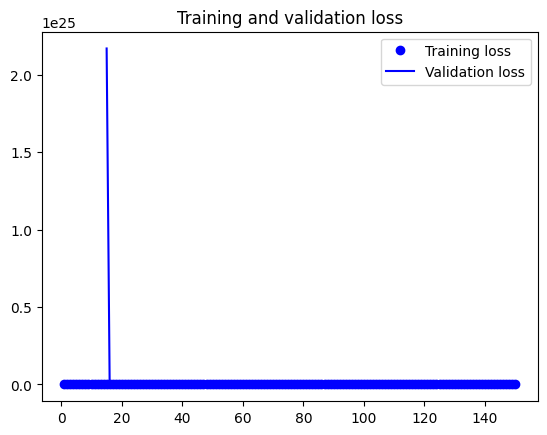

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


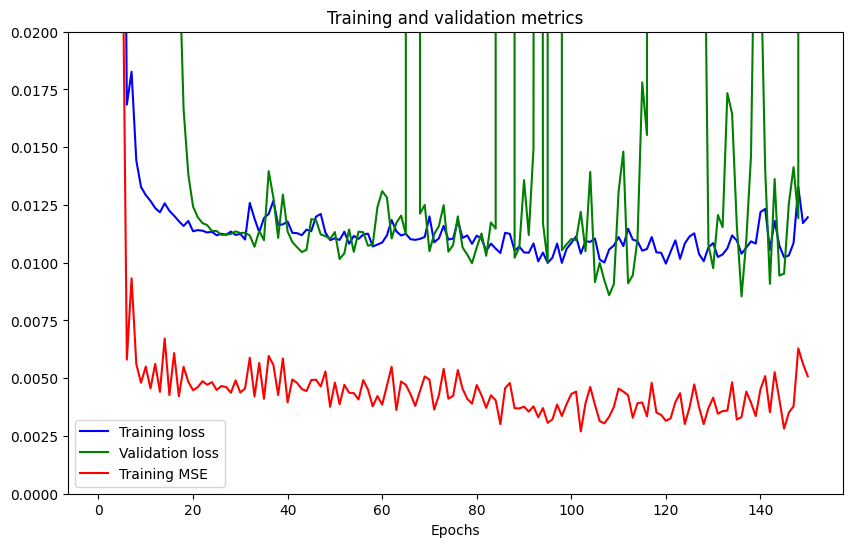

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plotting
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(10, 6))

    # Training loss, validation loss, training MSE, and validation MSE
    plt.plot(epochs, history.history['loss'], 'b-', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'g-', label='Validation loss')
    plt.plot(epochs, history.history['mse'], 'r-', label='Training MSE')

    plt.title('Training and validation metrics')
    plt.xlabel('Epochs')
    plt.legend()

    plt.ylim(0, 0.02)
    plt.show()

    # Return additional information if needed
    return {
        'loss': history.history['loss'],
        'mse': history.history['mse'],
        'val_loss': history.history['val_loss'],
        'val_mse': history.history['val_mse'],
        'lr': history.history['lr']
    }

history_info = plot_training_history(history)



#Test

In [7]:
# need the new data loader and output that is multiplied by the scaling factor
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.initializers import Constant

#from VAE import *
#from utils import npytar, save_volume

#def data_loader(fname):
    #reader = NpyTarReader(fname)
    #xc = np.zeros((reader.length(), ) + input_shape, dtype=np.uint16)
    #reader.reopen()
    #for ix, (x, name) in enumerate(reader):
        #xc[ix] = x.astype(np.uint16)
    #return xc

scaling_factor = 1.0 / 65535.0  # Divide by the maximum possible value for uint16


def data_loader(fname):
    reader = NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype=np.float32)  # Change dtype to float32
    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        # Scale the uint16 array to float32
        xc[ix] = (x.astype(np.float32) * scaling_factor)
    return xc

if __name__ == '__main__':
    model = get_model()

    inputs = model['inputs']
    outputs = model['outputs']
    mu = model['mu']
    sigma = model['sigma']
    z = model['z']
    encoder = model['encoder']
    decoder = model['decoder']
    vae = model['vae']


    # kl_div = -0.5 * K.mean(1 + 2 * sigma - K.square(mu) - K.exp(2 * sigma))
    #voxel_loss = K.cast(K.mean(weighted_binary_crossentropy(inputs, K.clip(sigmoid(outputs), 1e-7, 1.0 - 1e-7))), 'float32') # + kl_div
    #vae.add_loss(vae_loss)
    kl_loss = -0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
    kl_loss = K.mean(kl_loss)

    # Define the MSE loss
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))

    # Define the VAE loss
    beta = 0.00001  # Adjust the beta value as needed to control the trade-off
    vae_loss = reconstruction_loss + (beta * kl_loss)

    vae.add_loss(vae_loss)

    #sgd = SGD(lr = learning_rate_1, momentum = momentum, nesterov = True)
    vae.compile(optimizer = 'adam', loss=None, metrics = 'mse')


    vae.load_weights('/content/drive/MyDrive/vae_128.h5')

    data_test = data_loader('/content/drive/MyDrive/npy_brain_volumes_comp_128.tar')

    #get rid of binerization here
    reconstructions = vae.predict(data_test)
    #reconstructions[reconstructions > 0] = 1
    #reconstructions[reconstructions < 0] = 0

    if not os.path.exists('/content/drive/MyDrive/reconstructions_vae_128'):
        os.makedirs('/content/drive/MyDrive/reconstructions_vae_128')

    #save_volumes deleted
    for i in range(reconstructions.shape[0]):
        save_output(reconstructions[i, 0, :], 128, '/content/drive/MyDrive/reconstructions_vae_128', i)

2/2 [==============================] - 18s 3s/step


In [11]:
# SAME

# need the new data loader and output that is multiplied by the scaling factor
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

#from VAE import *
#from utils import npytar, save_volume

#def data_loader(fname):
    #reader = NpyTarReader(fname)
    #xc = np.zeros((reader.length(), ) + input_shape, dtype=np.uint16)
    #reader.reopen()
    #for ix, (x, name) in enumerate(reader):
        #xc[ix] = x.astype(np.uint16)
    #return xc

scaling_factor = 1.0 / 65535.0  # Divide by the maximum possible value for uint16


def data_loader(fname):
    reader = NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype=np.float32)  # Change dtype to float32
    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        # Scale the uint16 array to float32
        xc[ix] = (x.astype(np.float32) * scaling_factor)
    return xc

if __name__ == '__main__':
    model = get_model()

    inputs = model['inputs']
    outputs = model['outputs']
    mu = model['mu']
    sigma = model['sigma']
    z = model['z']
    encoder = model['encoder']
    decoder = model['decoder']
    vae = model['vae']


    # kl_div = -0.5 * K.mean(1 + 2 * sigma - K.square(mu) - K.exp(2 * sigma))
    #voxel_loss = K.cast(K.mean(weighted_binary_crossentropy(inputs, K.clip(sigmoid(outputs), 1e-7, 1.0 - 1e-7))), 'float32') # + kl_div
    #vae.add_loss(vae_loss)
    kl_loss = -0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
    kl_loss = K.mean(kl_loss)

    # Define the MSE loss
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))

    # Define the VAE loss
    beta = 0.00001  # Adjust the beta value as needed to control the trade-off
    vae_loss = reconstruction_loss + (beta * kl_loss)

    vae.add_loss(vae_loss)

    sgd = SGD(lr = learning_rate_1, momentum = momentum, nesterov = True)
    vae.compile(optimizer = 'adam', loss=None, metrics = 'mse')


    vae.load_weights('/content/drive/MyDrive/vae_64.h5')

    data_test = data_loader('/content/drive/MyDrive/npy_brain_volumes_comp_64.tar')

    #get rid of binerization here
    reconstructions = vae.predict(data_test)
    #reconstructions[reconstructions > 0] = 1
    #reconstructions[reconstructions < 0] = 0

    if not os.path.exists('/content/drive/MyDrive/reconstructions_vae_64'):
        os.makedirs('/content/drive/MyDrive/reconstructions_vae_64')

    #save_volumes deleted
    for i in range(reconstructions.shape[0]):
        save_output(reconstructions[i, 0, :], 64, '/content/drive/MyDrive/reconstructions_vae_64', i)

1/1 [==============================] - 1s 1s/step
Mean Squared Error (MSE): 0.001725785550661385
Structural Similarity Index (SSI): 0.8780737526708889


64 model 8 reconstructions
Mean Squared Error (MSE): 0.001725785550661385
Structural Similarity Index (SSI): 0.8780737526708889

#Generate synthetic data

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import os

# Assuming you have input_shape, learning_rate_1, momentum defined somewhere in your code
input_shape = (1, 128, 128, 128)
learning_rate_1 = 0.001
momentum = 0.9

latent_dime = 1024

def generate_synthetic_data(vae, num_samples=1, latent_dim=1024):
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))

    # Decode the latent vectors to generate synthetic data
    synthetic_data = decoder.predict(random_latent_vectors)

    return synthetic_data

if __name__ == '__main__':
    # Load your VAE model
    model = get_model()

    inputs = model['inputs']
    outputs = model['outputs']
    mu = model['mu']
    sigma = model['sigma']
    z = model['z']
    encoder = model['encoder']
    decoder = model['decoder']
    vae = model['vae']

    # Define the MSE loss
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))

    # Define the VAE loss
    beta = 0.00001  # Adjust the beta value as needed to control the trade-off
    kl_loss = -0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
    kl_loss = K.mean(kl_loss)
    vae_loss = reconstruction_loss + (beta * kl_loss)

    vae.add_loss(vae_loss)

    sgd = SGD(learning_rate=learning_rate_1, momentum=momentum, nesterov=True)
    vae.compile(optimizer='adam', loss=None, metrics='mse')

    vae.load_weights('/content/drive/MyDrive/vae_128.h5')

    # Generate synthetic data
    num_samples = 10  # Adjust as needed
    synthetic_data = generate_synthetic_data(vae, num_samples)

    # Save the synthetic data
    if not os.path.exists('/content/drive/MyDrive/synthetic_data_vae_128'):
        os.makedirs('/content/drive/MyDrive/synthetic_data_vae_128')

    for i in range(synthetic_data.shape[0]):
        save_output(synthetic_data[i, 0, :], 128, '/content/drive/MyDrive/synthetic_data_vae_128', i)
    # You can now use synthetic_data as your generated samples


1/1 [==============================] - 2s 2s/step


Test Generated Data

In [11]:
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import os
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.initializers import Constant
import shutil  # Import your NpyTarReader module
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
  # Import your NpyTarReader module

from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter


scaling_factor = 1.0 / 65535.0  # Divide by the maximum possible value for uint16


def data_loader(fname, input_shape, scaling_factor):
    reader = NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype=np.float32)
    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        # Scale the uint16 array to float32
        xc[ix] = (x.astype(np.float32) * scaling_factor)
    return xc

def calculate_mean_msi_ssi_mse(dataset1, dataset2, axis=0):
    mean_volume1 = np.mean(dataset1, axis=axis)
    mean_volume2 = np.mean(dataset2, axis=axis)

    # Calculate SSIM with a window function
    ssi_value = calculate_ssi(mean_volume1, mean_volume2)

    # Calculate MSE
    mse_value = mean_squared_error(mean_volume1.flatten(), mean_volume2.flatten())

    return ssi_value, mse_value, mean_volume1, mean_volume2


def calculate_ssi(volume1, volume2, epsilon=1e-8):
    try:
        # Apply Gaussian window before calculating SSIM
        gaussian_volume1 = gaussian_filter(volume1, sigma=1.5)
        gaussian_volume2 = gaussian_filter(volume2, sigma=1.5)

        ssi_value, _ = ssim(gaussian_volume1, gaussian_volume2, full=True)

        print(f"SSIM Value: {ssi_value}")

        return ssi_value / (ssi_value + epsilon)
    except ZeroDivisionError:
        return 0.0


def load_synthetic_data(directory, input_shape, scaling_factor):
    # List all files in the directory and sort them
    filenames = sorted(os.listdir(directory))

    synthetic_data = np.zeros((len(filenames),) + input_shape, dtype=np.float32)

    for i, filename in enumerate(filenames):
        file_path = os.path.join(directory, filename)
        synthetic_data[i, :, :, :] = np.load(file_path) * scaling_factor

    return synthetic_data


# Load your original dataset
input_shape = (128, 128, 128)  # Change this based on your input shape
scaling_factor = 1.0 / 65535.0  # Divide by the maximum possible value for uint16
data_test = data_loader('/content/drive/MyDrive/npy_brain_volumes_comp_128.tar', input_shape, scaling_factor)

# Load synthetic data from the saved directory
synthetic_data_directory = '/content/drive/MyDrive/synthetic_data_vae_128'
synthetic_data = load_synthetic_data(synthetic_data_directory, input_shape, scaling_factor)



# Calculate mean SSI, MSE, and get mean volumes
mean_ssi, mean_mse, mean_volume1, mean_volume2 = calculate_mean_msi_ssi_mse(data_test, synthetic_data, axis=0)

# Save the mean volumes as Numpy volumes
np.save('/content/mean_volume1_128.npy', mean_volume1)
np.save('/content/mean_volume2_128.npy', mean_volume2)

print(f"Mean SSI: {mean_ssi}")
print(f"Mean MSE: {mean_mse}")


SSIM Value: 0.0060789279337292185
Mean SSI: 0.9999983549758019
Mean MSE: 0.06499940156936646


For 64 model 8
SSIM Value: 0.005995987253528605
Mean SSI: 0.9999983322207171
Mean MSE: 0.06476819515228271

For 32 Model 8
SSIM Value: 0.0059011180202222764
Mean SSI: 0.9999983054087345
Mean MSE: 0.06425578892230988

For 128 Model 8
SSIM Value: 0.0060789279337292185
Mean SSI: 0.9999983549758019
Mean MSE: 0.06499940156936646

#Preprocess Data

#write, resize, save

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pydicom
from scipy import ndimage
import matplotlib.pyplot as plt

# List of full file paths

file_paths = [
    "/content/drive/MyDrive/pairs/selectedAnon/13/Unnamed - 547047837/Cerebral_Prop_Scan_5011/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/1/Unnamed - 565918441/Cerebral_Prop_Scan_5005/IM-0002-0384-0001.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/16/Unnamed - 586243163/Cerebral_Prop_Scan_5013/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/17/Unnamed - 570483378/Cerebral_Prop_Scan_5027/IM-0008-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/15/Unnamed - 620445097/Cerebral_Prop_Scan_5005/IM-0005-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/27/Unnamed - 499595919/Cerebral_Prop_Scan_5004/IM-0001-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/20/Unnamed - 532737128/Cerebral_Prop_Scan_5005/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/19/Unnamed - 573107231/Cerebral_Prop_Scan_5010/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/25/Unnamed - 538652806/Cerebral_Prop_Scan_5015/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/32/Unnamed - 581745116/Cerebral_Prop_Scan_5006/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/31/Cath_Lab_Image_Import - 107137242/Cerebral_Prop_Scan_5013/IM-0003-0384-0002.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/29/Unnamed - 603532774/Cerebral_Prop_Scan_5004/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/28/Unnamed - 556836670/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/33/Unnamed - 576051581/Cerebral_Prop_Scan_5015/IM-0012-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/34/Unnamed - 490781979/Cerebral_Prop_Scan_5005/IM-0001-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/30/Unnamed - 517125574/Cerebral_Prop_Scan_5009/IM-0005-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/43/Unnamed - 453687090/Cerebral_Prop_Scan_5015/IM-0008-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/44/Unnamed - 589154659/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/39/Unnamed - 404242476/Cerebral_Prop_Scan_5006/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/37/Unnamed - 587847239/Cerebral_Prop_Scan_5005/IM-0006-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/41/Unnamed - 589522182/Cerebral_Prop_Scan_5006/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/4/Unnamed - 586591744/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/38/Unnamed - 567915826/Cerebral_Prop_Scan_5008/IM-0006-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/54/Unnamed - 590054757/Cerebral_Prop_Scan_5008/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/53/Unnamed - 552763610/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/48/Unnamed - 541547416/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/50/Unnamed - 550213696/Cerebral_Prop_Scan_5011/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/55/Unnamed - 542666088/Cerebral_Prop_Scan_5004/IM-0001-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/57/Unnamed - 502164749/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/6/Unnamed - 574247875/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/60/Unnamed - 578001027/Cerebral_Prop_Scan_5009/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/61/Unnamed - 541013375/Cerebral_Prop_Scan_5013/IM-0007-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/56/Unnamed - 575767267/Cerebral_Prop_Scan_5007/IM-0008-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/59/Unnamed - 535367659/Cerebral_Prop_Scan_5012/IM-0008-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/58/Unnamed - 612369639/Cerebral_Prop_Scan_5005/IM-0003-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/63/Unnamed - 538763088/Cerebral_Prop_Scan_5007/IM-0006-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/65/Unnamed - 542111517/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/64/Unnamed - 559101851/Cerebral_Prop_Scan_5009/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/66/Unnamed - 549957970/Cerebral_Prop_Scan_5005/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/70/Unnamed - 538625806/Cerebral_Prop_Scan_5007/IM-0005-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/68/Unnamed - 539998733/Cerebral_Prop_Scan_5004/IM-0001-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/73/Unnamed - 594459865/Cerebral_Prop_Scan_5011/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/77/Unnamed - 571005720/Cerebral_Prop_Scan_5006/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/78/Unnamed - 540434142/Cerebral_Prop_Scan_5008/IM-0008-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/72/Unnamed - 507438992/Cerebral_Prop_Scan_5007/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/74/Unnamed - 553012123/Cerebral_Prop_Scan_5011/IM-0008-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/80/Unnamed - 594699062/Cerebral_Prop_Scan_5005/IM-0002-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/79/Unnamed - 536440500/Cerebral_Prop_Scan_5007/IM-0004-0384.dcm",
    "/content/drive/MyDrive/pairs/selectedAnon/83/Unnamed - 574581448/Cerebral_Prop_Scan_5014/IM-0005-0384.dcm"
]


# Define the target volume shape (384x384x384)
target_shape = (384, 384, 384)

output_folder = "/content/drive/MyDrive/raw_npy_volumes_384"
os.makedirs(output_folder, exist_ok=True)

# Iterate through the DICOM files and stack them to create the 3D volume
for file_path in file_paths:
    print(f"Processing DICOM file: {file_path}")
    dicom_data = pydicom.dcmread(file_path)

    # Initialize an empty 3D volume for each file
    volume_3d = np.zeros(target_shape, dtype=np.uint16)  # Use appropriate data type

    # Iterate through the DICOM images and stack them to create the 3D volume
    for i, dicom_slice in enumerate(dicom_data.pixel_array):
        # Resize each slice to match the target shape
        resized_slice = ndimage.zoom(dicom_slice, zoom=(target_shape[0] / dicom_slice.shape[0], target_shape[1] / dicom_slice.shape[1]), order=1)

        # Add the resized slice to the 3D volume
        volume_3d[:, :, i] = resized_slice


    path_parts = file_path.split("/")
    folder_path = os.path.join(*path_parts[-5:-1])
    output_path = f"{output_folder}/{folder_path}/{path_parts[-1].replace('.dcm', '_volume.npy')}"

    # Create the necessary directories for the output file
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save the 3D volume as a NumPy array with the unique name
    np.save(output_path, volume_3d)

    # Inform the user about the saved file
    print(f"Saved 3D volume as a NumPy array to {output_path}")


Processing DICOM file: /content/drive/MyDrive/pairs/selectedAnon/13/Unnamed - 547047837/Cerebral_Prop_Scan_5011/IM-0002-0384.dcm
Saved 3D volume as a NumPy array to /content/drive/MyDrive/raw_npy_volumes_384/selectedAnon/13/Unnamed - 547047837/Cerebral_Prop_Scan_5011/IM-0002-0384_volume.npy
Processing DICOM file: /content/drive/MyDrive/pairs/selectedAnon/1/Unnamed - 565918441/Cerebral_Prop_Scan_5005/IM-0002-0384-0001.dcm
Saved 3D volume as a NumPy array to /content/drive/MyDrive/raw_npy_volumes_384/selectedAnon/1/Unnamed - 565918441/Cerebral_Prop_Scan_5005/IM-0002-0384-0001_volume.npy
Processing DICOM file: /content/drive/MyDrive/pairs/selectedAnon/16/Unnamed - 586243163/Cerebral_Prop_Scan_5013/IM-0002-0384.dcm
Saved 3D volume as a NumPy array to /content/drive/MyDrive/raw_npy_volumes_384/selectedAnon/16/Unnamed - 586243163/Cerebral_Prop_Scan_5013/IM-0002-0384_volume.npy
Processing DICOM file: /content/drive/MyDrive/pairs/selectedAnon/17/Unnamed - 570483378/Cerebral_Prop_Scan_5027/IM-0

In [ ]:
import os
import numpy as np
from scipy.ndimage import zoom

# Define the source and destination folders
source_folder = '/content/drive/MyDrive/raw_npy_volumes_384'
destination_folder = '/content/drive/MyDrive/npy_volumes_resized_32'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Initialize a list to store the file paths
file_paths = []

# Define the target size (64x64x64)
target_size = (32, 32, 32)

# Iterate through the source folder
for root, _, files in os.walk(source_folder):
    for file in files:
        if file.endswith('.npy'):
            source_path = os.path.join(root, file)
            destination_path = os.path.join(destination_folder, file)

            # Load the original .npy file
            original_volume = np.load(source_path)

            # Check if the original volume's shape is 384x384x384
            if original_volume.shape != (384, 384, 384):
                print(f"Skipping {file} because its shape is {original_volume.shape}, not 384x384x384.")
                continue

            # Extract the part of the original file path to retain
            path_parts = root.split(os.path.sep)
            retain_path_part = os.path.join(*path_parts[-4:])  # Assuming that you want to retain the last 4 parts

            # Calculate the scaling factors for each dimension
            scale_factors = [
                float(target_size[i]) / original_volume.shape[i] for i in range(3)
            ]

            # Resize the volume using trilinear interpolation
            resized_volume = zoom(original_volume, zoom=scale_factors, order=1)

            # Save the resized volume as a new .npy file
            destination_path = os.path.join(destination_folder, retain_path_part, file)
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            np.save(destination_path, resized_volume)

            # Append the file path to the list
            file_paths.append(destination_path)

# Print the list of saved file paths
for path in file_paths:
    print("Saved 3D volume as a NumPy array to", path)


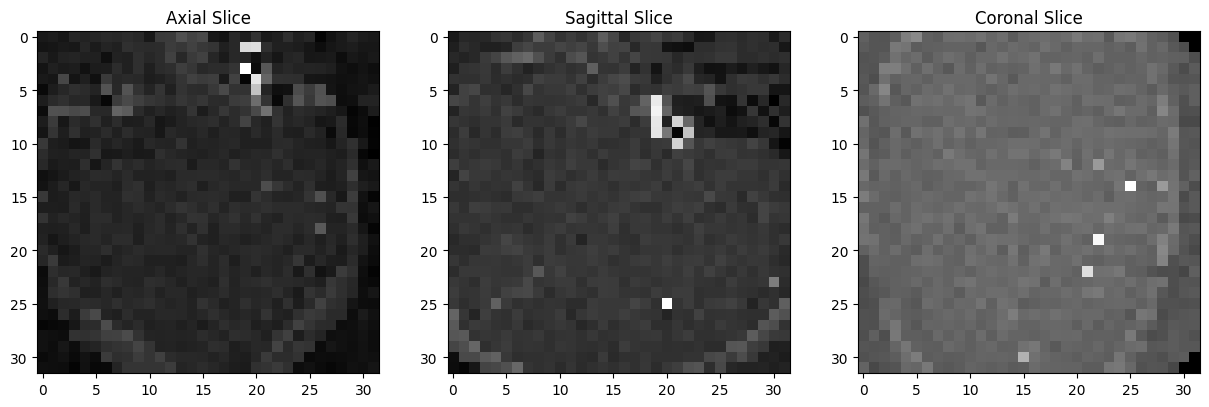

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved NumPy array (make sure the file path is correct)
file_path = '/content/drive/MyDrive/npy_volumes_resized_32/selectedAnon/25/Unnamed - 538652806/Cerebral_Prop_Scan_5015/IM-0002-0384_volume.npy'
volume = np.load(file_path)

# Create a figure with subplots for the slices
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display slices along different axes (adjust slice numbers as needed)
axs[0].imshow(volume[:, :, volume.shape[2] // 2], cmap='gray')
axs[0].set_title('Axial Slice')

axs[1].imshow(volume[:, volume.shape[1] // 2, :], cmap='gray')
axs[1].set_title('Sagittal Slice')

axs[2].imshow(volume[volume.shape[0] // 2, :, :].T, cmap='gray')
axs[2].set_title('Coronal Slice')

plt.show()


In [ ]:
import numpy as np

file_path = '/content/drive/MyDrive/npy_volumes_resized_32/selectedAnon/25/Unnamed - 538652806/Cerebral_Prop_Scan_5015/IM-0002-0384_volume.npy'
data = np.load(file_path)

# Examine properties of the loaded data
print("Data shape:", data.shape)
print("Data type:", data.dtype)

# Calculate data range
data_min = data.min()
data_max = data.max()
data_range = data_max - data_min

# Check if it's likely grayscale
is_grayscale = (data_range <= 255)

# Calculate additional statistics
data_mean = data.mean()
data_std = data.std()

print("Minimum value:", data_min)
print("Maximum value:", data_max)
print("Data range:", data_range)
print("Is grayscale:", is_grayscale)
print("Mean value:", data_mean)
print("Standard deviation:", data_std)


Data shape: (32, 32, 32)
Data type: uint16
Minimum value: 0
Maximum value: 60640
Data range: 60640
Is grayscale: False
Mean value: 16963.288513183594
Standard deviation: 2874.3346302407886


#Create .tar

In [ ]:
#NEW NPY WRITER NEED TO RECONCILE
import io
import tarfile
import time
import zlib

import numpy as np

PREFIX = 'data/'
SUFFIX = '.npy.z'

class NpyTarWriter(object):
    def __init__(self, fname):
        self.tfile = tarfile.open(fname, 'w|')
    def add(self, arr, name):
        # Convert the data to uint16 before saving
        arr_uint16 = arr.astype(np.uint16)
        sio = io.BytesIO()
        np.save(sio, arr_uint16)
        zbuf = zlib.compress(sio.getvalue())
        sio.close()

        zsio = io.BytesIO(zbuf)
        tinfo = tarfile.TarInfo('{}{}{}'.format(PREFIX, name, SUFFIX))
        tinfo.size = len(zbuf)
        tinfo.mtime = time.time()
        zsio.seek(0)
        self.tfile.addfile(tinfo, zsio)
        zsio.close()

    def close(self):
        self.tfile.close()

class NpyTarReader(object):
    def __init__(self, fname):
        self.fname = fname
        self.tfile = tarfile.open(self.fname, 'r|')

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        entry = self.tfile.next()
        if entry is None:
            raise StopIteration()
        name = entry.name[len(PREFIX): -len(SUFFIX)]
        fileobj = self.tfile.extractfile(entry)
        buf = zlib.decompress(fileobj.read())
        arr_uint16 = np.load(io.BytesIO(buf), allow_pickle=True)
        return arr_uint16, name

    def length(self):
        return len(self.tfile.getnames())

    def reopen(self):
        self.tfile.close()
        self.tfile = tarfile.open(self.fname, 'r|')

    def close(self):
        self.tfile.close()


In [18]:
import os
import tarfile
import numpy as np
import io
import time
import zlib

npy_directory = '/content/drive/MyDrive/npy_volumes_resized_128/selectedAnon/'
output_tar_file = '/content/drive/MyDrive/npy_brain_volumes_comp_128.tar'
PREFIX = 'data/'
SUFFIX = '.npy.z'

# Create an instance of the NpyTarWriter class
tar_writer = NpyTarWriter(output_tar_file)

# Iterate through subdirectories
for root, _, files in os.walk(npy_directory):
    for file in files:
        if file.endswith('.npy'):
            file_path = os.path.join(root, file)
            arr = np.load(file_path)
            # Set the name in metadata to the full file path
            name = npy_directory + os.path.relpath(file_path, npy_directory)  # Use the correct name
            # Add the NumPy array to the tar archive using the NpyTarWriter class
            tar_writer.add(arr, name)

# Close the tar file
tar_writer.close()

print(f"All .npy files from '{npy_directory}' have been added to '{output_tar_file}'.")


All .npy files from '/content/drive/MyDrive/npy_volumes_resized_128/selectedAnon/' have been added to '/content/drive/MyDrive/npy_brain_volumes_comp_128.tar'.


erroneous code

In [ ]:
import os
import tarfile
import numpy as np
import io
import time
import zlib

npy_directory = '/content/drive/MyDrive/npy_volumes_resized_32/selectedAnon/'
output_tar_file = '/content/drive/MyDrive/npy_brain_volumes_comp_32.tar'

# Create an instance of the NpyTarWriter class
tar_writer = NpyTarWriter(output_tar_file)

# Iterate through subdirectories
for root, _, files in os.walk(npy_directory):
    for file in files:
        if file.endswith('.npy'):
            file_path = os.path.join(root, file)
            np_array = np.load(file_path)
            # Set the name in metadata to the full file path
            name_in_tar = npy_directory + os.path.relpath(file_path, npy_directory)
            np_array_bytes = np.array(np_array).tobytes()
            # Add the NumPy array to the tar archive using the NpyTarWriter class
            tar_writer.add(np_array_bytes, name_in_tar)

# Close the tar file
tar_writer.close()

print(f"All .npy files from '{npy_directory}' have been added to '{output_tar_file}'.")


All .npy files from '/content/drive/MyDrive/npy_volumes_resized_32/selectedAnon/' have been added to '/content/drive/MyDrive/npy_brain_volumes_comp_32.tar'.


#Preprocessing

In [ ]:
import numpy as np
from scipy import ndimage

def preprocess_brain_volumes(brain_data):
    preprocessed_data = []

    for item in brain_data:
        data = item['data']

        # Intensity normalization (min-max scaling)
        min_val = np.min(data)
        max_val = np.max(data)
        data = (data - min_val) / (max_val - min_val)


        # Normalization (mean=0, std=1)
        mean = np.mean(data)
        std = np.std(data)
        data = (data - mean) / std

        preprocessed_data.append({
            'file_path': item['file_path'],
            'data': data
        })

    return preprocessed_data

# Example usage:
preprocessed_brain_data = preprocess_brain_volumes(brain_data)


NameError: ignored

In [ ]:
import numpy as np

# Save preprocessed_brain_data as a NumPy array to a specific directory
save_path = '/content/drive/MyDrive/preprocessed_brain_data_128.npy'
np.save(save_path, preprocessed_brain_data)


In [ ]:
def data_loader(fname):
    reader = npytar.NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype = np.float32)
    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        xc[ix] = x.astype(np.float32)
    return 3.0 * xc - 1.0

In [ ]:
import io
import tarfile
import time
import zlib

import numpy as np

PREFIX = 'data/'
SUFFIX = '.npy.z'

class NpyTarWriter(object):
    def __init__(self, fname):
        self.tfile = tarfile.open(fname, 'w|')

    def add(self, arr, name):

        sio = io.BytesIO()
        np.save(sio, arr)
        zbuf = zlib.compress(sio.getvalue())
        sio.close()

        zsio = io.BytesIO(zbuf)
        tinfo = tarfile.TarInfo('{}{}{}'.format(PREFIX, name, SUFFIX))
        tinfo.size = len(zbuf)
        tinfo.mtime = time.time()
        zsio.seek(0)
        self.tfile.addfile(tinfo, zsio)
        zsio.close()

    def close(self):
        self.tfile.close()

class NpyTarReader(object):
    def __init__(self, fname):
        self.fname = fname
        self.tfile = tarfile.open(self.fname, 'r|')

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        entry = self.tfile.next()
        if entry is None:
            raise StopIteration()
        name = entry.name[len(PREFIX): -len(SUFFIX)]
        fileobj = self.tfile.extractfile(entry)
        buf = zlib.decompress(fileobj.read())
        arr = np.load(io.BytesIO(buf))
        return arr, name

    def length(self):
        return len(self.tfile.getnames())

    def reopen(self):
        self.tfile.close()
        self.tfile = tarfile.open(self.fname, 'r|')

    def close(self):
        self.tfile.close()

In [ ]:

# Usage
fname = '/content/drive/MyDrive/shapenet10_test.tar'
loaded_data, metadata = data_loader(fname)
for i, (data, meta) in enumerate(zip(loaded_data, metadata)):
    print(f"Array {i + 1}:")
    print(f"Name: {meta['name']}")
    print(f"Prefix: {meta['prefix']}")
    print(f"Suffix: {meta['suffix']}")
    print(f"Shape: {meta['shape']}")
    # You can visualize the data or perform further processing as needed


In [ ]:
def plot_3d_volumes(fname, num_volumes_to_plot):
    reader = NpyTarReader(fname)

    # Initialize a list to store 3D volumes
    volumes = []

    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        if ix >= num_volumes_to_plot:
            break
        volumes.append(x)

    reader.close()

    # Plot 3D volumes
    fig = plt.figure(figsize=(15, 8))
    for i in range(num_volumes_to_plot):
        ax = fig.add_subplot(2, 3, i + 1, projection='3d')
        ax.voxels(volumes[i], facecolors='c', edgecolor='k')
        ax.set_title(f"Volume {i + 1}")

    plt.show()

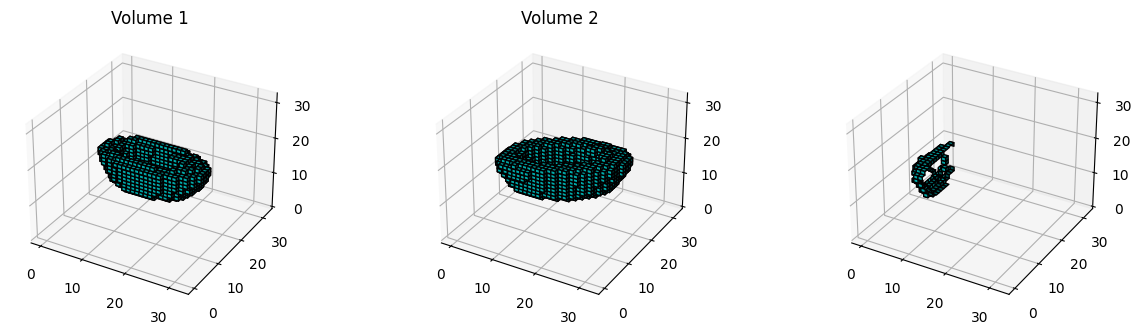

In [ ]:
# Usage
fname = '/content/drive/MyDrive/shapenet10_test.tar'
plot_3d_volumes(fname, num_volumes_to_plot=6)

In [ ]:
import tarfile
import numpy as np

def get_structure_info(tar_filename):
    structure_info = []

    # Open the tar file
    with tarfile.open(tar_filename, 'r') as tar:
        for member in tar.getmembers():
            # Check if the member is a file (not a directory)
            if member.isfile():
                # Extract the file
                with tar.extractfile(member) as file:
                    data = np.load(file, allow_pickle=True)  # Set allow_pickle to True
                    structure_info.append({
                        "name": member.name,
                        "shape": data.shape,
                        "dtype": data.dtype
                    })

    return structure_info

# File paths
tar_file1 = '/content/drive/MyDrive/npy_brain_volumes_comp_32.tar'
tar_file2 = '/content/drive/MyDrive/shapenet10_test.tar'

# Get structure info for both tar files
structure_info1 = get_structure_info(tar_file1)
structure_info2 = get_structure_info(tar_file2)

# Compare the structure info
for i, (info1, info2) in enumerate(zip(structure_info1, structure_info2)):
    print(f"Array {i + 1}:")
    print(f"Name (File 1): {info1['name']}")
    print(f"Name (File 2): {info2['name']}")
    print(f"Shape (File 1): {info1['shape']}")
    print(f"Shape (File 2): {info2['shape']}")
    print(f"Dtype (File 1): {info1['dtype']}")
    print(f"Dtype (File 2): {info2['dtype']}")
    if info1['shape'] == info2['shape'] and info1['dtype'] == info2['dtype']:
        print("Both arrays have the same structure and dtype.")
    else:
        print("Arrays have different structure or dtype.")


UnpicklingError: ignored

#Load Sample Data

In [ ]:
def data_loader(fname):
    reader = NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype = np.float32)
    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        xc[ix] = x.astype(np.float32)
    return 3.0 * xc - 1.0

In [ ]:
import io
import tarfile
import time
import zlib

import numpy as np

PREFIX = 'data/'
SUFFIX = '.npy.z'

class NpyTarWriter(object):
    def __init__(self, fname):
        self.tfile = tarfile.open(fname, 'w|')

    def add(self, arr, name):

        sio = io.BytesIO()
        np.save(sio, arr)
        zbuf = zlib.compress(sio.getvalue())
        sio.close()

        zsio = io.BytesIO(zbuf)
        tinfo = tarfile.TarInfo('{}{}{}'.format(PREFIX, name, SUFFIX))
        tinfo.size = len(zbuf)
        tinfo.mtime = time.time()
        zsio.seek(0)
        self.tfile.addfile(tinfo, zsio)
        zsio.close()

    def close(self):
        self.tfile.close()

class NpyTarReader(object):
    def __init__(self, fname):
        self.fname = fname
        self.tfile = tarfile.open(self.fname, 'r|')

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        entry = self.tfile.next()
        if entry is None:
            raise StopIteration()
        name = entry.name[len(PREFIX): -len(SUFFIX)]
        fileobj = self.tfile.extractfile(entry)
        buf = zlib.decompress(fileobj.read())
        arr = np.load(io.BytesIO(buf))
        return arr, name

    def length(self):
        return len(self.tfile.getnames())

    def reopen(self):
        self.tfile.close()
        self.tfile = tarfile.open(self.fname, 'r|')

    def close(self):
        self.tfile.close()

In [ ]:

# Usage
fname = '/content/drive/MyDrive/shapenet10_test.tar'
loaded_data, metadata = data_loader(fname)
for i, (data, meta) in enumerate(zip(loaded_data, metadata)):
    print(f"Array {i + 1}:")
    print(f"Name: {meta['name']}")
    print(f"Prefix: {meta['prefix']}")
    print(f"Suffix: {meta['suffix']}")
    print(f"Shape: {meta['shape']}")
    # You can visualize the data or perform further processing as needed


In [ ]:
def plot_3d_volumes(fname, num_volumes_to_plot):
    reader = NpyTarReader(fname)

    # Initialize a list to store 3D volumes
    volumes = []

    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        if ix >= num_volumes_to_plot:
            break
        volumes.append(x)

    reader.close()

    # Plot 3D volumes
    fig = plt.figure(figsize=(15, 8))
    for i in range(num_volumes_to_plot):
        ax = fig.add_subplot(2, 3, i + 1, projection='3d')
        ax.voxels(volumes[i], facecolors='c', edgecolor='k')
        ax.set_title(f"Volume {i + 1}")

    plt.show()

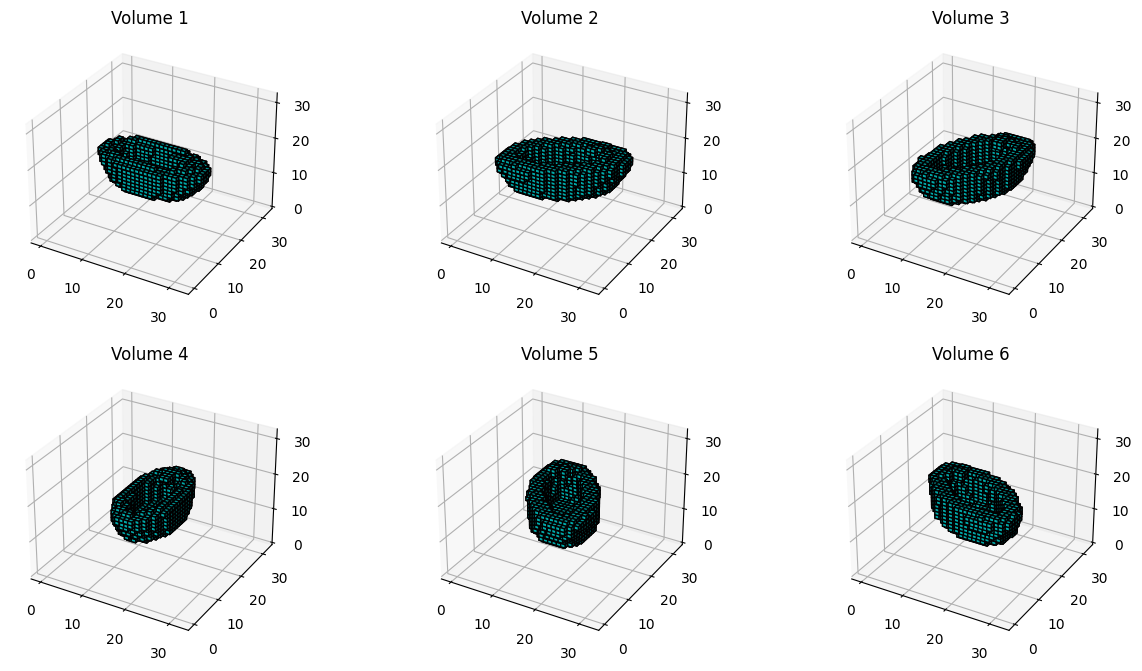

In [ ]:
# Usage
fname = '/content/drive/MyDrive/shapenet10_test.tar'
plot_3d_volumes(fname, num_volumes_to_plot=6)

#Load My Data

In [ ]:
def data_loader(fname):
    reader = npytar.NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype = np.float32)
    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        xc[ix] = x.astype(np.float32)
    return 3.0 * xc - 1.0

not importing utils **NOT PREPROCESSING**

In [ ]:
def data_loader(fname):
    reader = NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype=np.uint16)
    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        xc[ix] = x.astype(np.uint16)
    return xc


In [ ]:
input_shape = (1, 32, 32, 32)  # Define your input shape
fname = '/content/drive/MyDrive/npy_brain_volumes_comp_32.tar'
loaded_data = data_loader(fname)
xc = loaded_data

In [ ]:
#STATS It comes as Unit16 before float applied

import numpy as np

#scaling_factor = 1
#scaling_factor = 65535.0
scaling_factor = 1.0 / 65535.0  # Divide by the maximum possible value for uint16

def data_loader(fname):
    reader = NpyTarReader(fname)
    xc = np.zeros((reader.length(), ) + input_shape, dtype=np.float32)  # Change dtype to float32

    # Variables to store data type information
    data_types = set()
    data_type_counts = {}

    # List to store statistical distribution of data
    data_statistics = []

    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        # Scale the uint16 array to float32 using the scaling factor
        x_scaled = x.astype(np.float32) * scaling_factor
        xc[ix] = x_scaled

        # Collect data type information
        data_type = x_scaled.dtype
        data_types.add(data_type)
        data_type_counts[data_type] = data_type_counts.get(data_type, 0) + 1

        # Collect statistical distribution
        data_stats = {
            'min': np.min(x_scaled),
            'max': np.max(x_scaled),
            'mean': np.mean(x_scaled),
            'std': np.std(x_scaled)
        }
        data_statistics.append(data_stats)

    # Return data type information and statistical distribution
    return xc, data_types, data_type_counts, data_statistics

# Example usage
input_shape = (32,32,32)  # Define your input shape
fname = '/content/drive/MyDrive/npy_brain_volumes_comp_32.tar'  # Replace with the actual TAR file path
xc, data_types, data_type_counts, data_statistics = data_loader(fname)

# Print data type information
for data_type in data_types:
    print(f"Data Type: {data_type}, Count: {data_type_counts[data_type]}")

# Print statistical distribution
for ix, stats in enumerate(data_statistics):
    print(f"Stats for sample {ix + 1} - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}, Std: {stats['std']}")



Data Type: float32, Count: 49
Stats for sample 1 - Min: 0.0, Max: 0.7223315834999084, Mean: 0.2741183340549469, Std: 0.04188203066587448
Stats for sample 2 - Min: 0.0, Max: 0.8541695475578308, Mean: 0.23665115237236023, Std: 0.04434827342629433
Stats for sample 3 - Min: 0.0, Max: 0.6185396909713745, Mean: 0.2231341153383255, Std: 0.033059075474739075
Stats for sample 4 - Min: 0.0, Max: 0.798901379108429, Mean: 0.25217577815055847, Std: 0.037564318627119064
Stats for sample 5 - Min: 0.0, Max: 0.8237888216972351, Mean: 0.258943647146225, Std: 0.04817349836230278
Stats for sample 6 - Min: 0.0, Max: 0.730540931224823, Mean: 0.40928393602371216, Std: 0.03357744961977005
Stats for sample 7 - Min: 0.0, Max: 0.8565499186515808, Mean: 0.29811549186706543, Std: 0.05788400024175644
Stats for sample 8 - Min: 0.0, Max: 0.9159532785415649, Mean: 0.2298756241798401, Std: 0.04499427601695061
Stats for sample 9 - Min: 0.0, Max: 0.9253070950508118, Mean: 0.25884318351745605, Std: 0.043859533965587616
St

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Import NpyTarReader and other necessary libraries here

def plot_3d_volumes(fname, num_volumes_to_plot):
    reader = NpyTarReader(fname)

    # Initialize a list to store 3D volumes
    volumes = []

    reader.reopen()
    for ix, (x, name) in enumerate(reader):
        if ix >= num_volumes_to_plot:
            break
        volumes.append(x)

    reader.close()

    # Plot 3D volumes
    fig = plt.figure(figsize=(32, 32))
    for i in range(num_volumes_to_plot):

        # Display axial, sagittal, and coronal slices
        ax = fig.add_subplot(2, 3, 3 + i * 2)
        ax.imshow(volumes[i][:, :, volumes[i].shape[2] // 2], cmap='gray')
        ax.set_title('Axial Slice')

        ax = fig.add_subplot(2, 3, 4 + i * 2)
        ax.imshow(volumes[i][:, volumes[i].shape[1] // 2, :], cmap='gray')
        ax.set_title('Sagittal Slice')

        ax = fig.add_subplot(2, 3, 5 + i * 2)
        ax.imshow(volumes[i][volumes[i].shape[0] // 2, :, :].T, cmap='gray')
        ax.set_title('Coronal Slice')

    plt.show()


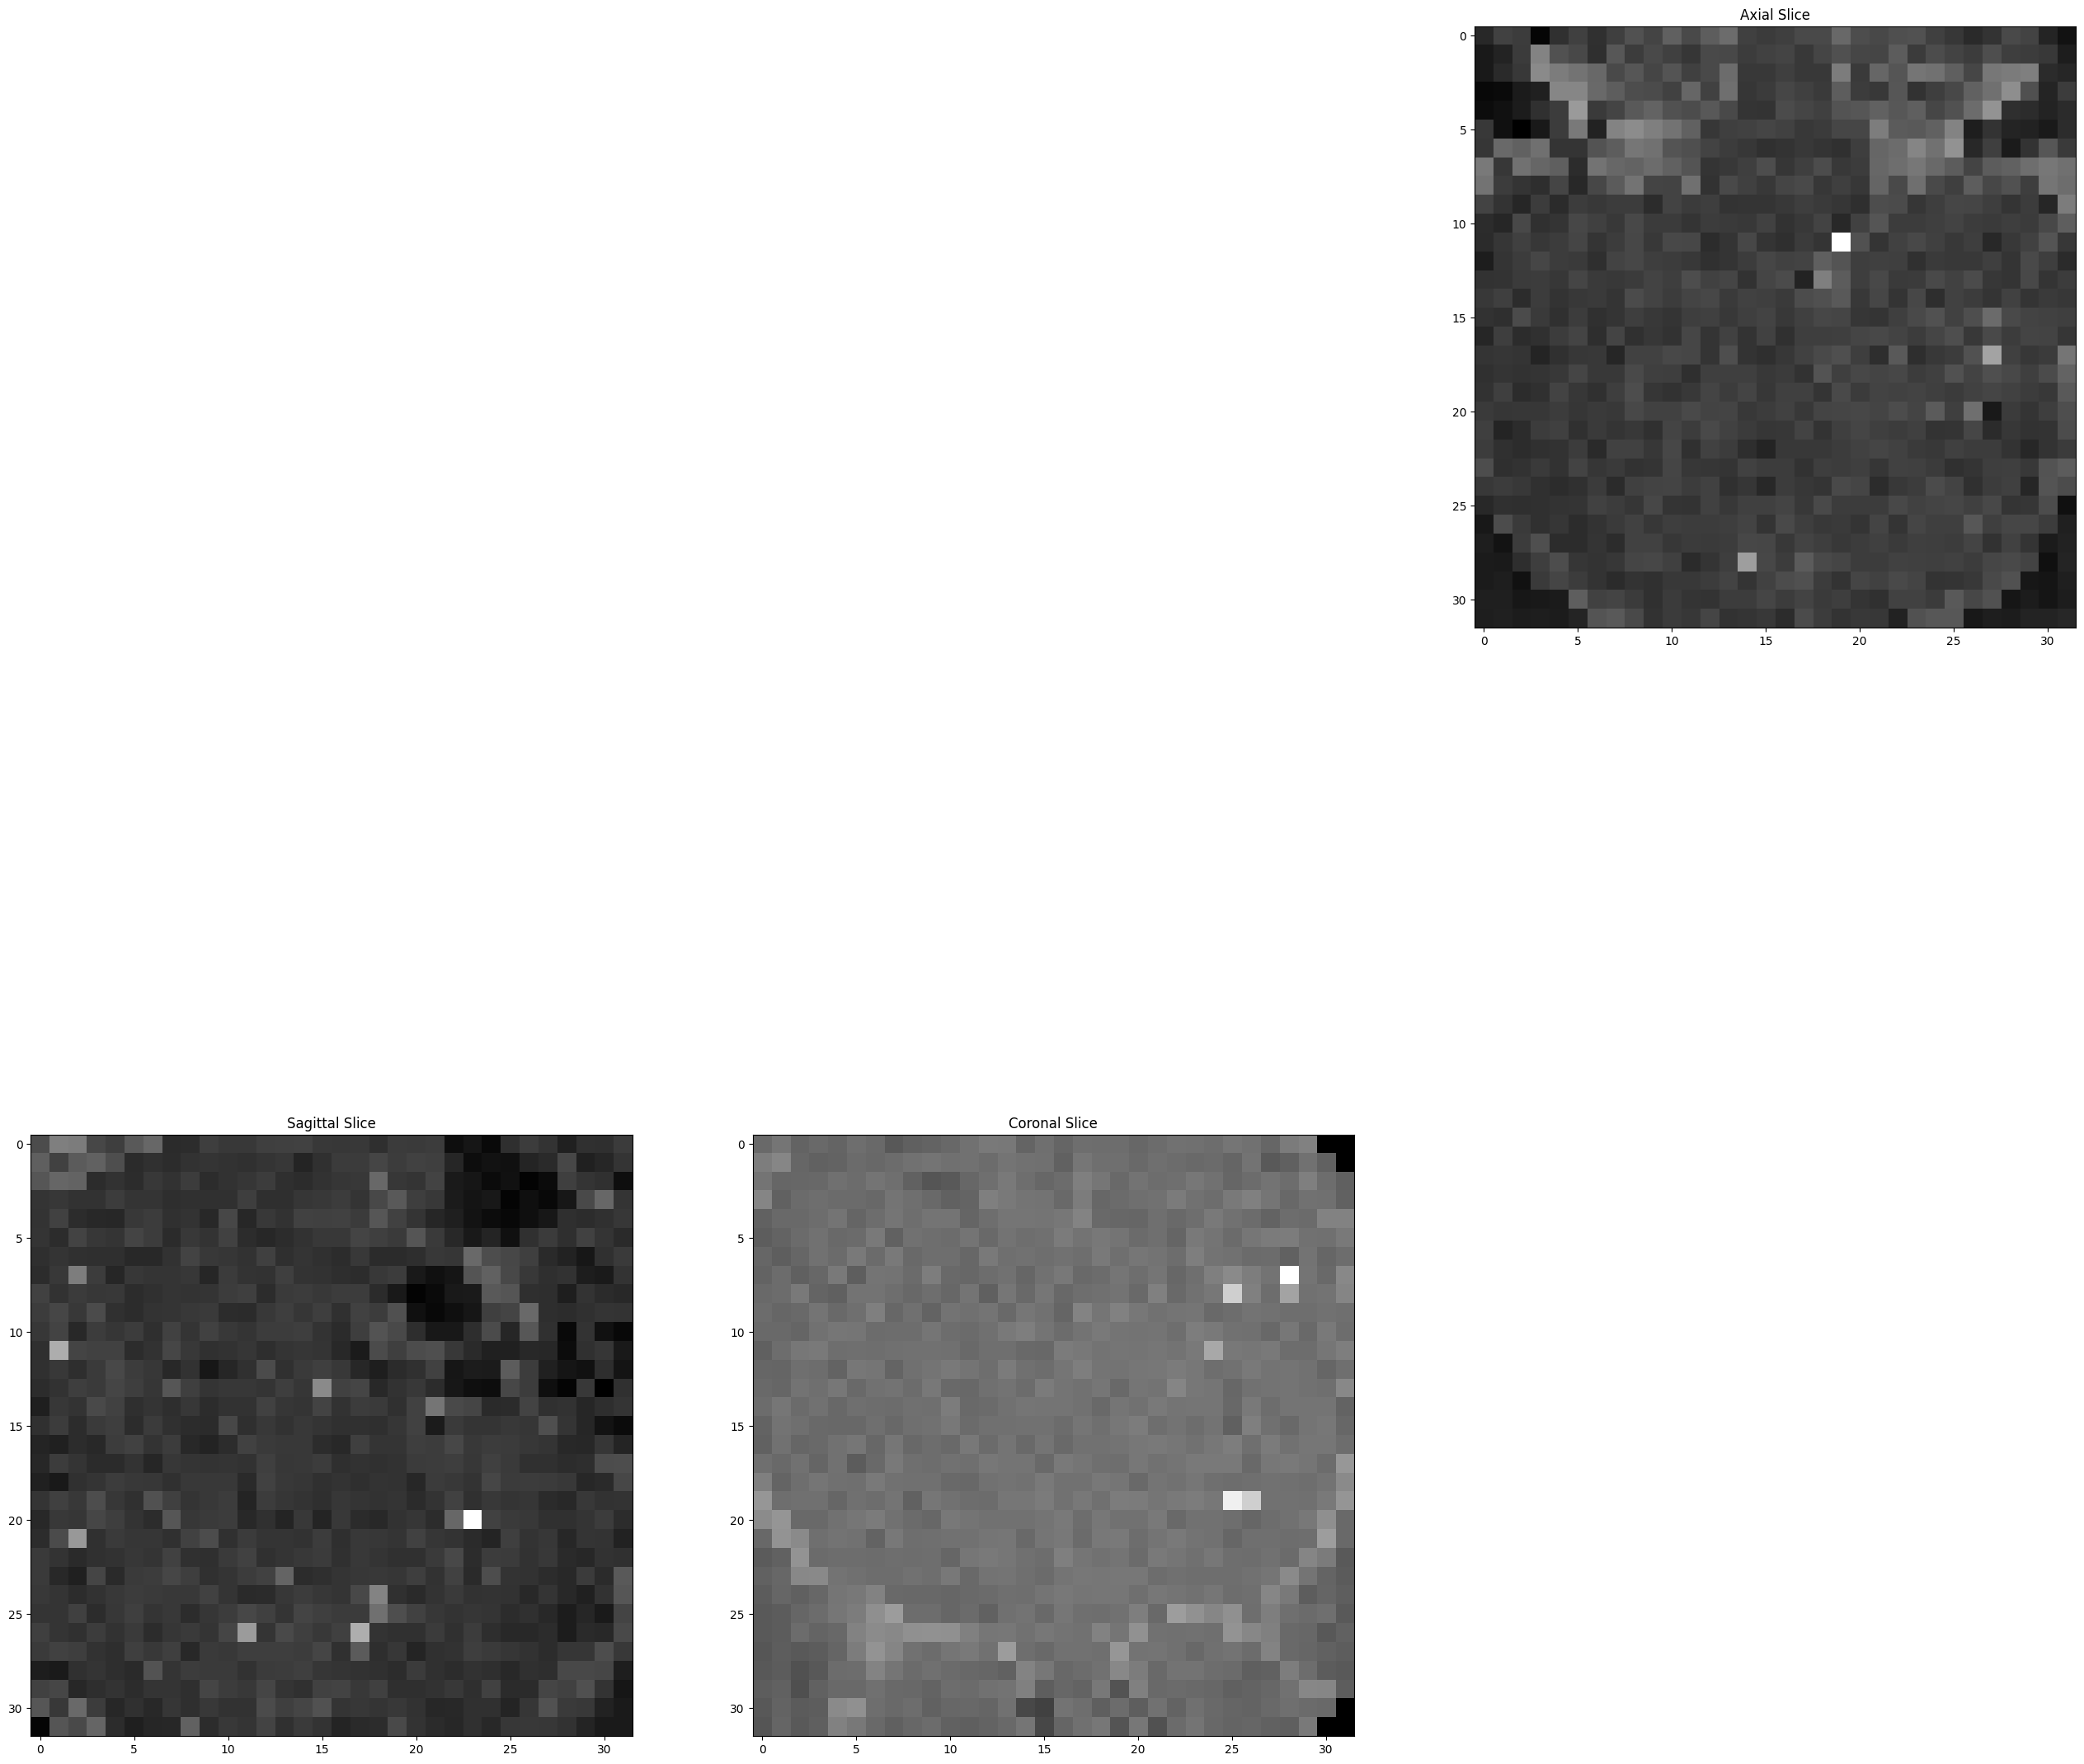

In [ ]:
fname = '/content/drive/MyDrive/npy_brain_volumes_comp_32.tar'
plot_3d_volumes(fname, num_volumes_to_plot=1)

#RECONSTRUCTION

In [34]:
#works
import numpy as np
import matplotlib.pyplot as plt

def plot_3d_volume(fname):
    # Load the NPY file
    volume = np.load(fname)

    # Plot 3D volume
    fig = plt.figure(figsize=(8, 8))

    # Display axial, sagittal, and coronal slices
    ax = fig.add_subplot(2, 2, 1)
    ax.imshow(volume[:, :, volume.shape[2] // 2], cmap='gray')
    ax.set_title('Axial Slice')

    ax = fig.add_subplot(2, 2, 2)
    ax.imshow(volume[:, volume.shape[1] // 2, :], cmap='gray')
    ax.set_title('Sagittal Slice')

    ax = fig.add_subplot(2, 2, 3)
    ax.imshow(volume[volume.shape[0] // 2, :, :].T, cmap='gray')
    ax.set_title('Coronal Slice')

    ax = fig.add_subplot(2, 2, 4, projection='3d')
    x, y, z = volume.nonzero()
    ax.scatter(x, y, z, zdir='z', c='red')
    ax.set_title('3D Plot')

    plt.show()




In [22]:
import numpy as np
import matplotlib.pyplot as plt

#scaling_factor = 1.0 / 65535.0  # Divide by the maximum possible value for uint16
scaling_factor =  65535.0
#scaling_factor = 1.0

def plot_3d_volume(fname):
    # Load the NPY file
    volume = np.load(fname)

    # Apply the scaling factor
    volume = volume * scaling_factor

    # Plot 3D volume
    fig = plt.figure(figsize=(8, 8))

    # Display axial, sagittal, and coronal slices
    ax = fig.add_subplot(2, 2, 1)
    ax.imshow(volume[:, :, volume.shape[2] // 2], cmap='gray')
    ax.set_title('Axial Slice')

    ax = fig.add_subplot(2, 2, 2)
    ax.imshow(volume[:, volume.shape[1] // 2, :], cmap='gray')
    ax.set_title('Sagittal Slice')

    ax = fig.add_subplot(2, 2, 3)
    ax.imshow(volume[volume.shape[0] // 2, :, :].T, cmap='gray')
    ax.set_title('Coronal Slice')

    ax = fig.add_subplot(2, 2, 4, projection='3d')
    x, y, z = volume.nonzero()
    ax.scatter(x, y, z, zdir='z', c='red')
    ax.set_title('3D Plot')

    plt.show()


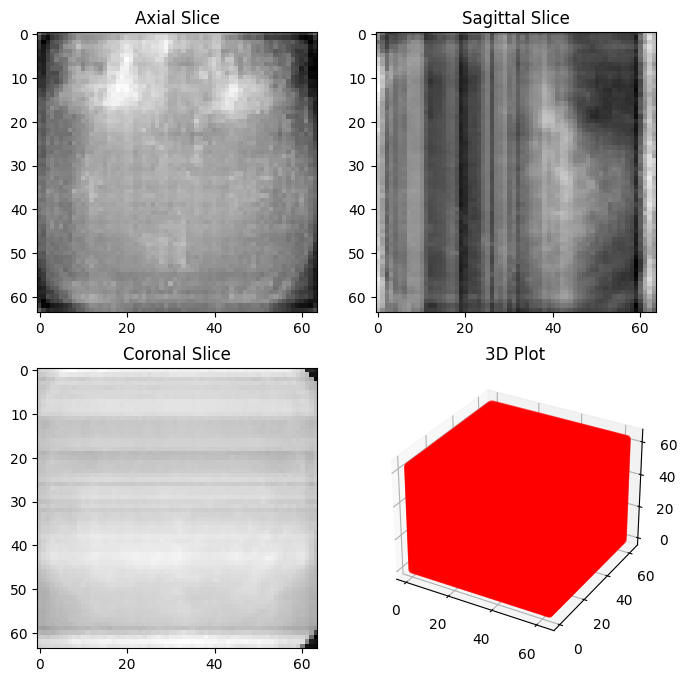

In [25]:
plot_3d_volume('/content/drive/MyDrive/synthetic_data_vae_64/volume0.npy')


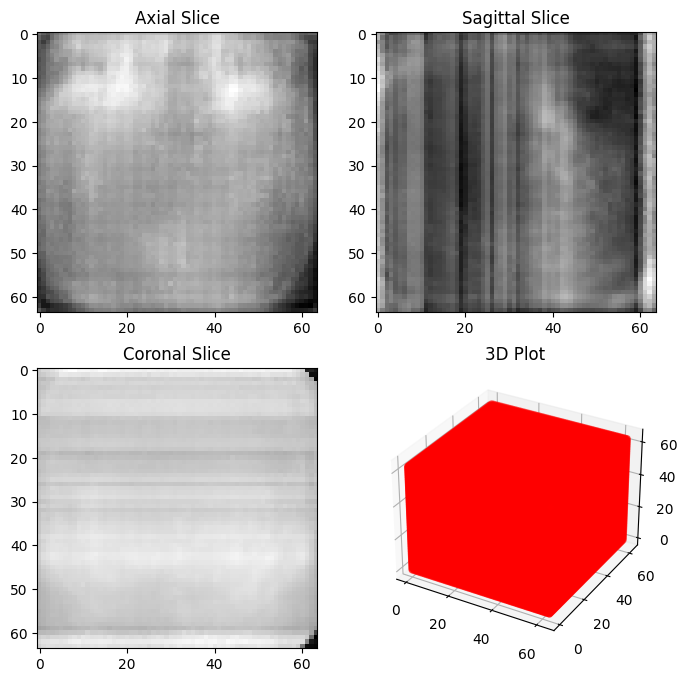

In [41]:
plot_3d_volume('/content/drive/MyDrive/reconstructions_vae_64/volume4.npy')


In [ ]:
import os
import numpy as np

#scaling_factor = 1.0 / 65535.0  # Divide by the maximum possible value for uint16
#scaling_factor =  65535.0
scaling_factor = 1.0

def collect_stats_from_directory(directory_path):
    data_types = set()
    data_type_counts = {}
    data_statistics = []

    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith('.npy'):
                file_path = os.path.join(root, filename)
                data = np.load(file_path)
                data_scaled = data.astype(np.float32) * scaling_factor

                # Collect data type information
                data_type = data_scaled.dtype
                data_types.add(data_type)
                data_type_counts[data_type] = data_type_counts.get(data_type, 0) + 1

                # Collect statistical distribution
                data_stats = {
                    'min': np.min(data_scaled),
                    'max': np.max(data_scaled),
                    'mean': np.mean(data_scaled),
                    'std': np.std(data_scaled)
                }
                data_statistics.append(data_stats)

    return data_types, data_type_counts, data_statistics

# Example usage
directory_path = '/content/drive/MyDrive/Reconstructions_base_1000eps'  # Replace with the actual path to your directory
data_types, data_type_counts, data_statistics = collect_stats_from_directory(directory_path)

# Print data type information
for data_type in data_types:
    print(f"Data Type: {data_type}, Count: {data_type_counts[data_type]}")

# Print statistical distribution
for ix, stats in enumerate(data_statistics):
    print(f"Stats for file {ix + 1} - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}, Std: {stats['std']}")


Data Type: float32, Count: 49
Stats for file 1 - Min: 0.18829810619354248, Max: 0.26779410243034363, Mean: 0.24504560232162476, Std: 0.01132158376276493
Stats for file 2 - Min: 0.1905117779970169, Max: 0.2669203281402588, Mean: 0.24478615820407867, Std: 0.011064713820815086
Stats for file 3 - Min: 0.18783701956272125, Max: 0.2690800130367279, Mean: 0.2454201579093933, Std: 0.010953951627016068
Stats for file 4 - Min: 0.1940128058195114, Max: 0.26429885625839233, Mean: 0.24453160166740417, Std: 0.010927258990705013
Stats for file 5 - Min: 0.1918489634990692, Max: 0.2620880901813507, Mean: 0.2441447377204895, Std: 0.01109984703361988
Stats for file 6 - Min: 0.19152115285396576, Max: 0.26668819785118103, Mean: 0.24469906091690063, Std: 0.011171136982738972
Stats for file 7 - Min: 0.1926385760307312, Max: 0.2656058073043823, Mean: 0.2444988191127777, Std: 0.01107671670615673
Stats for file 8 - Min: 0.18739931285381317, Max: 0.26703158020973206, Mean: 0.24478691816329956, Std: 0.01111325249

In [ ]:
fname = "/content/drive/MyDrive/Reconstructions_base_1000eps/volumes.tar"
plot_3d_volumes(fname, num_volumes_to_plot=1)

ValueError: ignored

#Local Runtime

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4900559351993941789
xla_global_id: -1
]


In [ ]:
!pip install tensorflow


In [ ]:
!pip install torch

In [ ]:
import torch

torch.cuda.get_device_name(0)



'NVIDIA RTX A5000'

In [ ]:
!pip install torch torchvision torchaudio


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: ignored

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
import tensorflow as tf

# Check the version of CUDA
print("CUDA version: ", tf.test.is_built_with_cuda())

# Check the cuDNN version
cudnn_version = tf.sysconfig.get_lib()
print("cuDNN version: ", cudnn_version)


CUDA version:  False
cuDNN version:  C:\Users\Pepperdine\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow


In [ ]:
import tensorflow as tf


# Check if GPU is available
print("GPU available: ", tf.config.list_physical_devices('GPU'))


ImportError: ignored

In [ ]:
!tensorflow --version

'tensorflow' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip3 install tensorflow.python._pywrap_tensorflow_internal import


ERROR: Could not find a version that satisfies the requirement tensorflow.python._pywrap_tensorflow_internal (from versions: none)
ERROR: No matching distribution found for tensorflow.python._pywrap_tensorflow_internal


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
!nvidia-smi

Sat Nov  4 21:10:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000             WDDM  | 00000000:01:00.0  On |                  Off |
| 30%   30C    P8              17W / 230W |    460MiB / 24564MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install tensorflow

In [ ]:
>>> gpu_available = tf.test.is_gpu_available()
>>> is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
>>> is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
tf.device("/device:GPU:0")

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # If GPUs are available, print information about them
    for gpu in gpus:
        print(f"Name: {gpu.name}, Memory: {gpu.memory_limit}")
else:
    print("No GPU devices found. TensorFlow will use the CPU.")

No GPU devices found. TensorFlow will use the CPU.


In [ ]:
python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"


SyntaxError: ignored

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
curl https://repo.anaconda.com/miniconda/Miniconda3-latest-Windows-x86_64.exe -o miniconda.exe
start /wait "" miniconda.exe /S
del miniconda.exe

SyntaxError: ignored

In [ ]:
!source activate myenv && conda env list


'source' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!which conda


'which' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!conda update conda -y -q
!source /usr/local/etc/profile.d/conda.sh
!conda init
!conda install -n root _license -y -q

'conda' is not recognized as an internal or external command,
operable program or batch file.
'source' is not recognized as an internal or external command,
operable program or batch file.
'conda' is not recognized as an internal or external command,
operable program or batch file.
'conda' is not recognized as an internal or external command,
operable program or batch file.


#Conda Setup

In [ ]:
!which python


'which' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!python --version


Python 3.11.5


In [ ]:
!echo $PYTHONPATH


$PYTHONPATH


In [ ]:
%env PYTHONPATH=


env: PYTHONPATH=


In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

Couldn't find program: 'bash'


In [ ]:
import sys
print(sys.version)

!python --version

3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
Python 3.11.5


In [ ]:
!conda create --name myenv python=3.9


'conda' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!python3 -m venv jd


In [ ]:
!source jd/bin/activate


'source' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install numpy
!pip install tensorflow


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
!pip install -q condacolab

In [ ]:
!pip install -q condalab

import condacolab
condacolab.install()

ERROR: Could not find a version that satisfies the requirement condalab (from versions: none)
ERROR: No matching distribution found for condalab


RuntimeError: ignored

In [ ]:
Miniconda3-latest-Windows-x86_64.exe

In [ ]:
!curl -o Miniconda3-py37_4.9.2-Miniconda3-latest-Windows-x86_64.exe https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Miniconda3-latest-Windows-x86_64.exe

!icacls Miniconda3-py37_4.9.2-Miniconda3-latest-Windows-x86_64.exe /grant Users:(RX)

!Miniconda3-py37_4.9.2-Miniconda3-latest-Windows-x86_64.exe /InstallationType=JustMe /AddToPath=0 /S /D=C:\Miniconda



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to open the file 

100   403  100   403    0     0   2013      0 --:--:-- --:--:-- --:--:--  2025
curl: (23) Failure writing output to destination


Successfully processed 0 files; Failed processing 1 files


Miniconda3-py37_4.9.2-Miniconda3-latest-Windows-x86_64.exe: The system cannot find the file specified.
'Miniconda3-py37_4.9.2-Miniconda3-latest-Windows-x86_64.exe' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=423a2515cccdac2948df7b84298bebb9151ea736ab4381147e7d7b05930bdd0c
  Stored in directory: c:\users\pepperdine\appdata\local\pip\cache\wheels\40\b3\0f\a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.9.2-Linux-x86_64.sh
!bash Miniconda3-py37_4.9.2-Linux-x86_64.sh -b -f -p /usr/local


--2023-11-04 23:17:07--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90040905 (86M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.9.2-Linux-x86_64.sh’

Miniconda3-py37_4.9 100%[===================>]  85.87M  96.5MB/s    in 0.9s    

2023-11-04 23:17:08 (96.5 MB/s) - ‘Miniconda3-py37_4.9.2-Linux-x86_64.sh’ saved [90040905/90040905]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2020.10.14=0
    - certifi==2020.6.20=pyhd3eb1b0_3
    - cffi==1.14.3=py37h261ae71_2
    - chardet==3.0.4=py37h06a4308_1003
    - conda-pack

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]
